# Day 1-2 measurements and sample discussion

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import mplhep as hep

from utils import angle_data
from utils.style import make_style
make_style()

from utils.angle_data import AngleData, SingleRun, get_data
# from utils import fresnel

import glob 

Loading datasets

Angular distribution for normal incidence over photodiode


In [2]:
normal_dist_files = sorted(glob.glob('../data/normal_dist/**'))
nd_adl = get_data(normal_dist_files, 23)

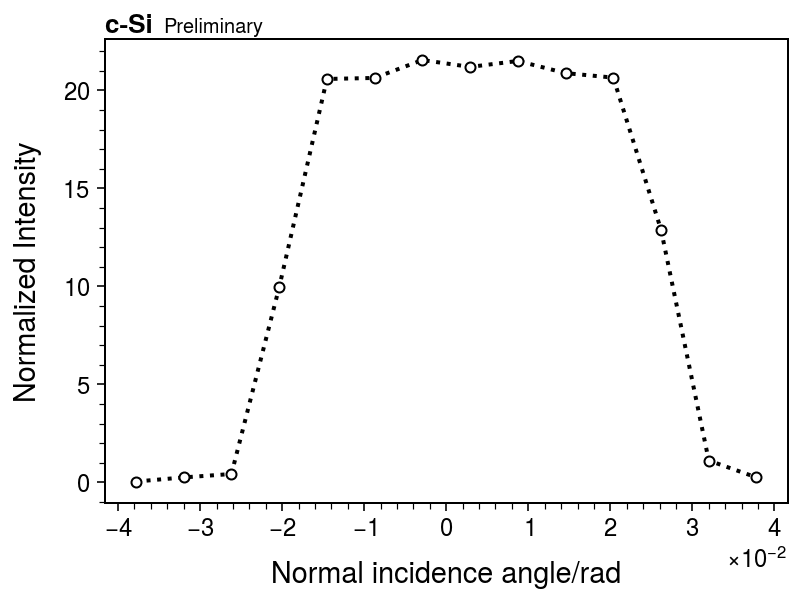

In [3]:
nd_s1 = SingleRun(nd_adl)

center = nd_s1.angles.mean()
nd_s1.angles -= center

from scipy import integrate
integral = integrate.simpson(nd_s1.reflectance, dx=np.abs(nd_s1.angles[1]-nd_s1.angles[0]))
nd_s1.reflectance = nd_s1.reflectance/integral

nd_s1.plot(marker='o:')
hep.label.exp_text('c-Si ', 'Preliminary')
plt.ylabel('Normalized Intensity')
plt.savefig('angle_spread.pdf', bbox_inches='tight')

In [4]:
files_dSi1_s = sorted(glob.glob('../data/dataSi_1/**.lvm'))
files_dSi0_s = sorted(glob.glob('../data/dataSi_0/**.lvm'))

dSi1_s_adl = get_data(files_dSi1_s, 23)
dSi0_s_adl = get_data(files_dSi0_s, 23)

In [5]:
dSi1_s = SingleRun(dSi1_s_adl, dSi1_s_adl[-1])


In [6]:
dSi0_s = SingleRun(dSi0_s_adl, dSi0_s_adl[-1])

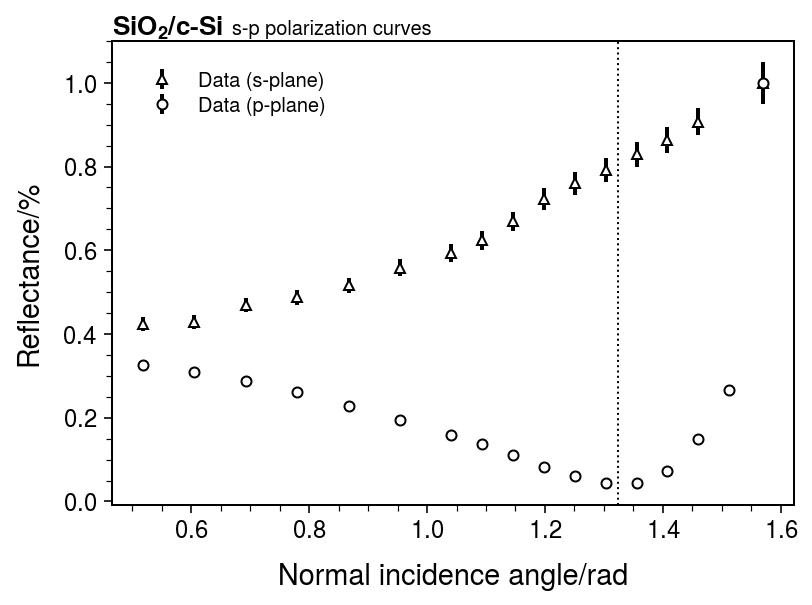

In [7]:
dSi0_s.plot(color='k', marker='^')
dSi1_s.plot(color='k', marker='o')

plt.axvline(np.arctan(3.9669), color='k', ls=':', lw=1)
hep.label.exp_text('SiO$\mathbf{_2}$/c-Si ', 's-p polarization curves')
plt.legend()

Refractive index goes like $$
R_\mathrm{s} = \left|\frac{n_1 \cos \theta_\mathrm{i} - n_2 \cos \theta_\mathrm{t}}{n_1 \cos \theta_\mathrm{i} + n_2 \cos \theta_\mathrm{t}}\right|^2
               = \left|\frac
                         {n_1 \cos \theta_{\mathrm{i}} - n_2 \sqrt{1 - \left(\frac{n_1}{n_2} \sin \theta_{\mathrm{i}}\right)^2}}
                         {n_1 \cos \theta_{\mathrm{i}} + n_2 \sqrt{1 - \left(\frac{n_1}{n_2} \sin \theta_{\mathrm{i}}\right)^2}}
                 \right|^2
$$$$
  R_\mathrm{p} = \left|\frac{n_1 \cos \theta_\mathrm{t} - n_2 \cos \theta_\mathrm{i}}{n_1 \cos \theta_\mathrm{t} + n_2 \cos \theta_\mathrm{i}}\right|^2
               = \left|\frac
                         {n_1 \sqrt{1 - \left(\frac{n_1}{n_2} \sin \theta_\mathrm{i}\right)^2} - n_2 \cos \theta_\mathrm{i}}
                         {n_1 \sqrt{1 - \left(\frac{n_1}{n_2} \sin \theta_\mathrm{i}\right)^2} + n_2 \cos \theta_\mathrm{i}}
                 \right|^2
$$

In [14]:
def r_s(theta, ni, nt):
    '''Compute r_s fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    
    cos_transmitted = np.sqrt(1 - ((ni/nt) * np.sin(theta))**2)
    return (
        (ni * np.cos(theta) - nt * cos_transmitted) / (ni * np.cos(theta) + nt * cos_transmitted)
    )

def r_p(theta, ni, nt):
    '''Compute r_p fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    cos_transmitted = np.sqrt(1 - ((ni/nt) * np.sin(theta))**2)
    return (
        (nt * np.cos(theta) - ni * cos_transmitted) / (ni * cos_transmitted + nt * np.cos(theta))
    )
    
def phi(theta, ni, nt, d): 
    cos_transmitted = np.sqrt(1 - ((ni/nt) * np.sin(theta))**2)
    return 2 * np.pi * d * nt/ 532e-9 * cos_transmitted
    
def construct_three_layer_r(r: callable, theta, n1, n2, n3, d):
    '''Compute r_p fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    `n3`: complex refractive indices for material 3 (n = n + k*1j)
    `d` : inner layer width
    '''
    
    return (
        (r(theta, n1, n2) + r(theta, n2, n3) * np.exp(-2j * phi(theta, n1, n2, d)))/
        (1 + r(theta, n1, n2) * r(theta, n2, n3) * np.exp(-2j * phi(theta, n1, n2, d)))
    )

In [15]:

def c_Si_Rs(theta, n1, n2, n3, d):
    rs_tot = construct_three_layer_r(r_s, theta, n1, n2, n3, d)
    return np.abs( rs_tot * np.conj(rs_tot) )

def c_Si_Rp(theta, n1, n2, n3, d):
    rp_tot = construct_three_layer_r(r_p, theta, n1, n2, n3, d)
    return np.abs( rp_tot * np.conj(rp_tot) )


In [16]:
from iminuit import Minuit, minuit

def fcn_c_Si(n1, k1, n2, k2, n3, k3, d):
    fcn = 0.0
    for x, y, std in zip(dSi0_s.angles, dSi0_s.reflectance, dSi0_s.reflectance_std):
        fcn += ((y - c_Si_Rs(x, n1+k2*1j, n2+k2*1j, n3+k3*1j,d)) / std)**2
    for x, y, std in zip(dSi1_s.angles, dSi1_s.reflectance, dSi1_s.reflectance_std):
        fcn += ((y - c_Si_Rp(x, n1+k2*1j, n2+k2*1j, n3+k3*1j,d)) / std)**2
    return fcn

n_Air  = 1.00027821
n_SiO2 = 1.4607
n_c_Si = 4.1360
k_c_Si = 0.010205

m_c_Si = Minuit(fcn_c_Si, n1=n_Air, k1=0., n2=n_SiO2, k2=0., n3=n_c_Si, k3=k_c_Si, d=2e-9)

In [17]:
# m_c_Si.limits['n1'] = (0, 2)
# m_c_Si.limits['k1'] = (-1, 1)
# m_c_Si.limits['n2'] = (0., 2)
# m_c_Si.limits['k2'] = (-0.1, 0.1)
# m_c_Si.limits['n3'] = (2.5, 5)
# m_c_Si.limits['k3'] = (0.01, 0.02)
# m_c_Si.limits['d']  = (1e-9, 5e-9)


In [21]:
m_c_Si.migrad()
m_c_Si.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6003                       │             Nfcn = 1403              │
│ EDM = 7.82e-07 (Goal: 0.0002)    │            time = 1.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   Hesse FAILED   │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n1   │ 8.6823e-1 │ 0.0000e-1 │            │            │         │         │       │
│ 1 │ k1   │     0     │     0     │            │            │         │         │       │
│ 2 │ n2   │ 8.6684e-1 │ 0.0000e-1 │            │            │         │         │       │
│ 3 │ k2   │-8.1522e-2 │ 0.0000e-2 │            │            │         │         │       │
│ 4 │ n3   │  3.3234   │  0.0000   │            │            │         │         │       │
│ 5 │ k3   │  1.1822   │  0.0000   │            │            │         │         │       │
│ 6 │ d    │ 2.8187e-8 │ 0.0000e-8 │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

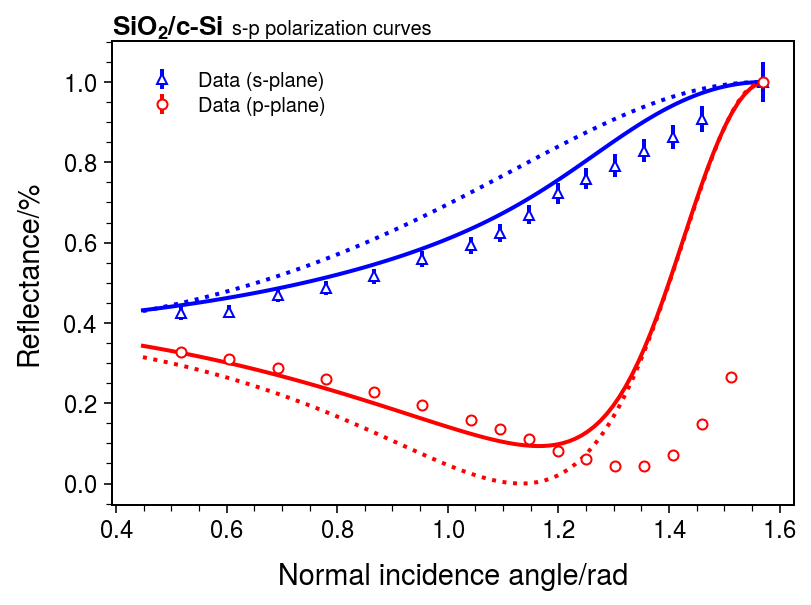

In [19]:
dSi0_s.plot(color='b', marker='^')
dSi1_s.plot(color='r')
fangles = np.linspace(np.pi/7, np.pi/2, 100)
n1,k1,n2,k2,n3,k3,d = m_c_Si.values
plt.plot(fangles, c_Si_Rs(fangles, n1+k1*1j, n2+k2*1j, n3+k3*1j, d), color='b')
plt.plot(fangles, c_Si_Rp(fangles, n1+k1*1j, n2+k2*1j, n3+k3*1j, d), color='r')

plt.plot(fangles, c_Si_Rs(fangles, n_Air, n_SiO2, n_c_Si+k_c_Si*1j, 2e-9), color='b', ls=':')
plt.plot(fangles, c_Si_Rp(fangles, n_Air, n_SiO2, n_c_Si+k_c_Si*1j, 2e-9), color='r', ls=':')
hep.label.exp_text('SiO$\mathbf{_2}$/c-Si ', 's-p polarization curves')
# plt.yscale('log')
plt.legend()


Analyzing Au data

In [39]:
dAu0_adl = get_data(sorted(glob.glob('../data/dataAu_0/**.lvm')), 23)
dAu1_adl = get_data(sorted(glob.glob('../data/dataAu_1/**.lvm')), 23)

(exptext: Custom Text(0.0, 1, 'Au '),
 expsuffix: Custom Text(0.0, 1.005, 's-p polarization curves'))

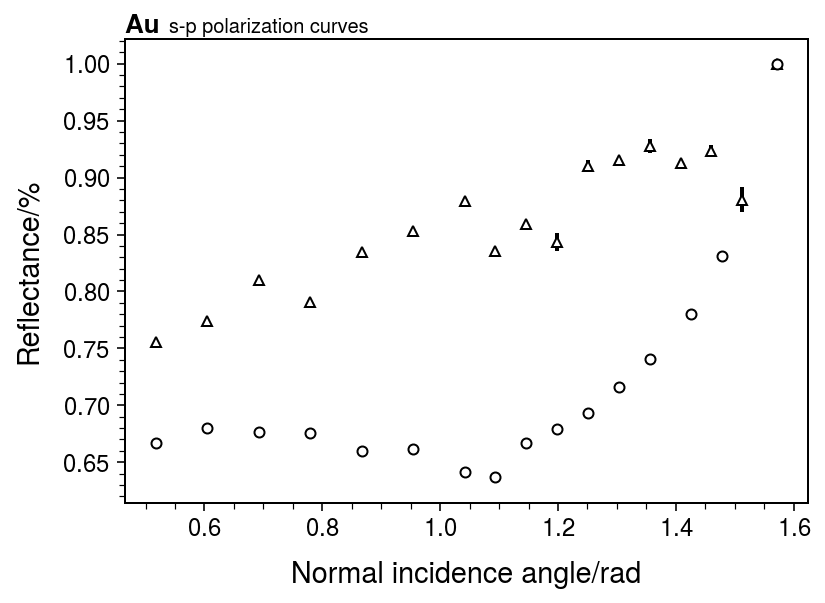

In [40]:
dAu0_s = SingleRun(dAu0_adl, dAu0_adl[-1])
dAu1_s = SingleRun(dAu1_adl, dAu1_adl[-1])
dAu0_s.plot(marker='^')
dAu1_s.plot()

hep.label.exp_text('Au ', 's-p polarization curves')


In [46]:
def Au_Rs(theta, n1, n2):
    rs = r_s(theta, n1, n2)
    return np.abs( rs * np.conj(rs) )

def Au_Rp(theta, n1, n2):
    rp = r_p(theta, n1, n2)
    return np.abs( rp * np.conj(rp) )

In [47]:
def fcn_Au(n1, k1, n2, k2):
    fcn = 0.0
    for x, y, std in zip(dAu0_s.angles, dAu0_s.reflectance, dAu0_s.reflectance_std):
        fcn += ((y - Au_Rs(x, n1+k2*1j, n2+k2*1j)) / std)**2
    for x, y, std in zip(dAu1_s.angles, dAu1_s.reflectance, dAu1_s.reflectance_std):
        fcn += ((y - Au_Rp(x, n1+k2*1j, n2+k2*1j)) / std)**2
    return fcn

n_Air  = 1.00027821
n_Au   = 0.54463
k_Au   = 2.1406

m_Au = Minuit(fcn_Au, n1=n_Air, k1=0, n2=n_Au, k2=k_Au)
m_Au.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3952                       │              Nfcn = 510              │
│ EDM = 5.48e-08 (Goal: 0.0002)    │            time = 0.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   Hesse FAILED   │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n1   │ 7.3088e3  │ 0.0000e3  │            │            │         │         │       │
│ 1 │ k1   │     0     │     0     │            │            │         │         │       │
│ 2 │ n2   │ -3.1267e4 │ 0.0000e4  │            │            │         │         │       │
│ 3 │ k2   │ 1.8883e4  │ 0.0000e4  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘